In [1]:
#!sudo /opt/conda/bin/conda install conda-build -y

In [2]:
#!sudo /opt/conda/bin/conda-develop -n QML-QPF PATH /workspaces/QML-QPF/mosaiQue

In [3]:

#import tensorflow as tf
#from tensorflow import keras
import mosaique as mq
from concurrent.futures import ProcessPoolExecutor, as_completed
import itertools
import numpy as np
import pennylane as qml
import os
import time
from mosaique.models.operation import OperationLayer
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


def operation():
    dev = qml.device("default.qubit.tf", wires=4)
    @qml.qnode(dev, interface='tf')
    def cnot(inputs):

        qml.AngleEmbedding(inputs[:,...], wires=range(4), rotation='Y')

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(4)]
    return cnot

2024-11-21 03:56:35.985765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 03:56:36.709297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:

from tensorflow import keras
mnist_dataset = keras.datasets.mnist
tr_layer = mq.ConvolutionLayer4x4("mnist_train2")
te_layer = mq.ConvolutionLayer4x4("mnist_test2")
(tr_images, tr_labels), (te_images, te_labels) = mnist_dataset.load_data()
(tr_images, tr_labels), (te_images, te_labels) = (tr_images[:20], tr_labels[:20]), (te_images[:20], te_labels[:20])
tr_layer.fit(tr_images)
te_layer.fit(te_images)
tr_images = tr_layer.transform(tr_images)
te_images = te_layer.transform(te_images)


In [5]:
permutations = np.asarray(list(itertools.permutations(range(4))))

op = OperationLayer(operation())
predict = op.pre_op.predict(tr_images)

predict.shape


2024-11-21 03:56:37.775884: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:238] Using CUDA malloc Async allocator for GPU: 0
2024-11-21 03:56:37.776176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5
I0000 00:00:1732161398.481799  944491 service.cc:145] XLA service 0x76aa8c013ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732161398.481868  944491 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-11-21 03:56:38.519876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 03:56:38.590349: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1732161398.939333  944491 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(20, 196, 4)

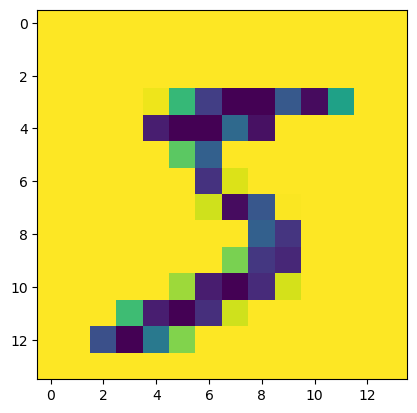

In [6]:
from matplotlib import pyplot as plt

plt.imshow(tr_layer.post_transform(predict)[0,:,:,1])

In [7]:
tr_images.shape

(20, 196, 4)

In [8]:
operate = np.asarray([operation()(tr_images[i,...]/255.) for i in range(20)])

In [9]:
operate.shape

(20, 4, 196)

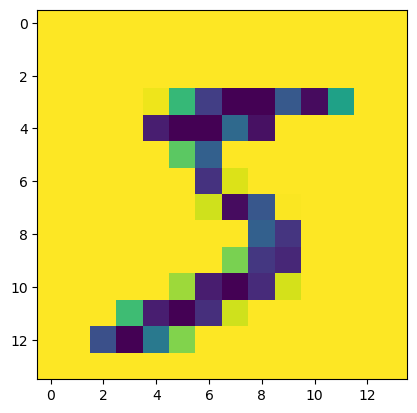

In [10]:
orz = operate.reshape(20,4,14,14)

plt.imshow(orz.transpose((0,2,3,1))[0][:,:,1])